In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

from datetime import datetime
import pandas as pd
import numpy as np
import pdb

from cesium import featurize

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

# from sklearn.metrics.pairwise import pairwise_distances
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.cluster import homogeneity_score, completeness_score
from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics.cluster import homogeneity_score

from collections import Counter

from dtaidistance import dtw

In [2]:
words = pd.read_csv('https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/50words_TEST.csv',
                   header = None)

In [3]:
words.rename(columns = {0:'word'}, inplace = True)

In [4]:
words.head()

,word,1,2,3,4,5,6,7,8,9,...,261,262,263,264,265,266,267,268,269,270
0,4,-0.89094,-0.86099,-0.82438,-0.78214,-0.73573,-0.68691,-0.63754,-0.589370,-0.543420,...,-0.86309,-0.86791,-0.87271,-0.87846,-0.88592,-0.89619,-0.90783,-0.91942,-0.93018,-0.93939
1,12,-0.78346,-0.68562,-0.58409,-0.47946,-0.37398,-0.27008,-0.17225,-0.087463,-0.019191,...,-0.88318,-0.89189,-0.90290,-0.91427,-0.92668,-0.93966,-0.95244,-0.96623,-0.98050,-0.99178
2,13,-1.32560,-1.28430,-1.21970,-1.15670,-1.09980,-1.04960,-1.01550,-0.996720,-0.985040,...,-0.83499,-0.86204,-0.88559,-0.90454,-0.93353,-0.99135,-1.06910,-1.13680,-1.19800,-1.27000
3,23,-1.09370,-1.04200,-0.99840,-0.95997,-0.93997,-0.93764,-0.92649,-0.857090,-0.693320,...,-0.72810,-0.74512,-0.76376,-0.78068,-0.80593,-0.84350,-0.89531,-0.96052,-1.05090,-1.12830
4,4,-0.90138,-0.85228,-0.80196,-0.74932,-0.69298,-0.63316,-0.57038,-0.506920,-0.446040,...,-0.95452,-0.97322,-0.98984,-1.00520,-1.01880,-1.02960,-1.03700,-1.04110,-1.04180,-1.04030


Text(0.5, 0.98, 'Sample word projections and histograms of the projections')

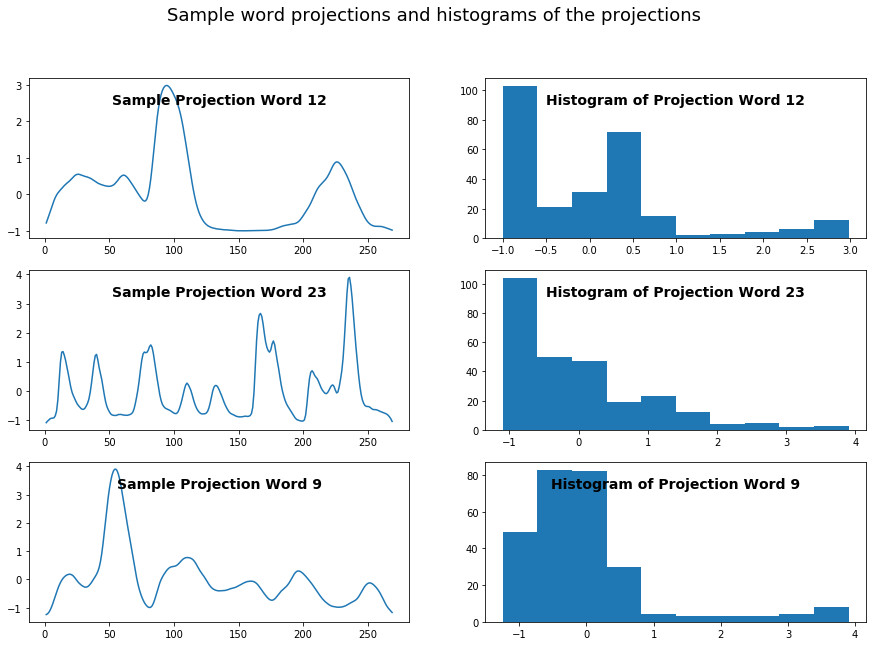

In [5]:
plt.subplot(3, 2, 1)
plt.plot(words.iloc[1, 1:-1])
plt.title("Sample Projection Word " + str(words.word[1]), fontweight = 'bold', y = 0.8, fontsize = 14)
plt.subplot(3, 2, 2)
plt.hist(words.iloc[1, 1:-1], 10)
plt.title("Histogram of Projection Word " + str(words.word[1]), fontweight = 'bold', y = 0.8, fontsize = 14)
plt.subplot(3, 2, 3)
plt.plot(words.iloc[3, 1:-1])
plt.title("Sample Projection Word " + str(words.word[3]), fontweight = 'bold', y = 0.8, fontsize = 14)
plt.subplot(3, 2, 4)
plt.hist(words.iloc[3, 1:-1], 10)
plt.title("Histogram of Projection Word " + str(words.word[3]), fontweight = 'bold', y = 0.8, fontsize = 14)
plt.subplot(3, 2, 5)
plt.plot(words.iloc[5, 1:-1])
plt.title("Sample Projection Word " + str(words.word[11]), fontweight = 'bold', y = 0.8, fontsize = 14)
plt.subplot(3, 2, 6)
plt.hist(words.iloc[5, 1:-1], 10)
plt.title("Histogram of Projection Word " + str(words.word[11]), fontweight = 'bold', y = 0.8, fontsize = 14)
plt.suptitle("Sample word projections and histograms of the projections", fontsize = 18)

Text(0, 0.5, 'Value')

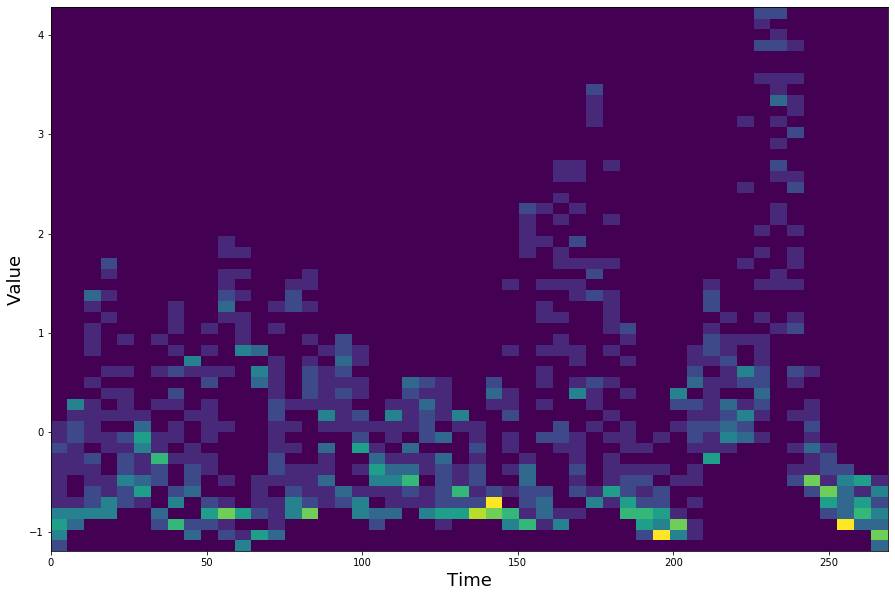

In [6]:
x = np.array([])
y = np.array([])

w = 23
selected_words = words[words.word == w]
selected_words.shape

for idx, row in selected_words.iterrows():
    y = np.hstack([y, row[1:271]])
    x = np.hstack([x, np.array(range(270))])
    
fig, ax = plt.subplots()
hist = ax.hist2d(x, y, bins = 50)
plt.xlabel("Time", fontsize = 18)
plt.ylabel("Value", fontsize = 18)

In [7]:
words_features = words.iloc[:, 1:271]

times  = []
values = []
for idx, row in words_features.iterrows():
    values.append(row.values)
    times.append(np.array([i for i in range(row.values.shape[0])]))
    
features_to_use = ["amplitude",
                   "percent_beyond_1_std",
                   "percent_close_to_median",
                   ]
featurized_words = featurize.featurize_time_series(times=times,
                                              values=values,
                                              errors=None,
                                              features_to_use=features_to_use,
                                              scheduler = None)

In [8]:
featurized_words.columns = featurized_words.columns.droplevel(-1)
featurized_words.head()

feature,amplitude,percent_beyond_1_std,percent_close_to_median
0,1.674555,0.188889,0.451852
1,1.990520,0.118519,0.259259
2,2.903650,0.114815,0.637037
3,2.515050,0.211111,0.562963
4,1.966150,0.181481,0.533333


(array([ 48., 146., 100.,  45.,  41.,  29.,  23.,  12.,   8.,   3.]),
 array([0.05925926, 0.10666667, 0.15407407, 0.20148148, 0.24888889,
        0.2962963 , 0.3437037 , 0.39111111, 0.43851852, 0.48592593,
        0.53333333]),
 <a list of 10 Patch objects>)

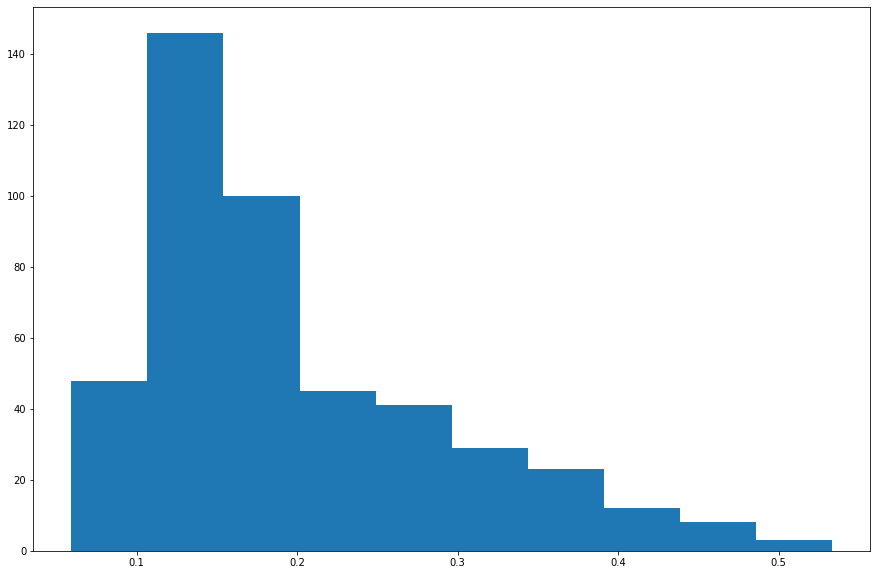

In [9]:
plt.hist(featurized_words.percent_beyond_1_std)

In [10]:
times = []
values = []
for idx, row in words_features.iterrows():
    values.append(np.histogram(row.values, bins=10, range=(-2.5, 5.0))[0] + .0001) ## cesium seems not to handle 0s
    times.append(np.array([i for i in range(9)]))

In [11]:
features_to_use = ["amplitude",
                   "percent_close_to_median",
                  "skew"
                  ]
featurized_hists = featurize.featurize_time_series(times=times,
                                              values=values,
                                              errors=None,
                                              features_to_use=features_to_use,
                                              scheduler = None)

In [12]:
featurized_hists.columns = featurized_hists.columns.droplevel(-1)
featurized_hists.head()

feature,amplitude,percent_close_to_median,skew
0,88.0,0.444444,2.262655
1,61.0,0.666667,1.285343
2,70.0,0.666667,1.683031
3,67.0,0.555556,1.724109
4,75.0,0.777778,1.902513


In [13]:
features = pd.concat([featurized_words.reset_index(drop=True), featurized_hists], axis=1)

In [14]:
features.head()

feature,amplitude,percent_beyond_1_std,percent_close_to_median,amplitude,percent_close_to_median,skew
0,1.674555,0.188889,0.451852,88.0,0.444444,2.262655
1,1.990520,0.118519,0.259259,61.0,0.666667,1.285343
2,2.903650,0.114815,0.637037,70.0,0.666667,1.683031
3,2.515050,0.211111,0.562963,67.0,0.555556,1.724109
4,1.966150,0.181481,0.533333,75.0,0.777778,1.902513


In [15]:
feats = np.zeros( (words.shape[0], 1), dtype = np.float32)
for i in range(words.shape[0]):
    vals = words.iloc[i, 1:271].values
    feats[i, 0] = np.where(vals == np.max(vals))[0][0]

In [16]:
features['peak_location'] = feats

In [17]:
features.head()

feature,amplitude,percent_beyond_1_std,percent_close_to_median,amplitude,percent_close_to_median,skew,peak_location
0,1.674555,0.188889,0.451852,88.0,0.444444,2.262655,186.0
1,1.990520,0.118519,0.259259,61.0,0.666667,1.285343,93.0
2,2.903650,0.114815,0.637037,70.0,0.666667,1.683031,69.0
3,2.515050,0.211111,0.562963,67.0,0.555556,1.724109,235.0
4,1.966150,0.181481,0.533333,75.0,0.777778,1.902513,174.0


In [18]:
features.shape

(455, 7)

In [19]:
feature_values = preprocessing.scale(features.iloc[:, [0, 1, 2, 3, 5, 6]])

In [20]:
clustering = AgglomerativeClustering(n_clusters=50, linkage='ward')
clustering.fit(feature_values)
words['feature_label'] = clustering.labels_

In [21]:
words['feature_label'] = words.feature_label.astype('category')

In [22]:
pre_agg = words.groupby('word')['feature_label']

In [23]:
result = pd.DataFrame()
result['num_clustering_labels'] = pre_agg.aggregate(lambda x: len(set(x)))
result['num_word_samples'] = pre_agg.aggregate(lambda x: len(x))
result['most_common_label'] = pre_agg.aggregate(lambda x: Counter(x).most_common(1)[0][0])

result.head()

,num_clustering_labels,num_word_samples,most_common_label
word,,,
1,15,57,25
2,14,42,34
3,13,28,2
4,15,34,11
5,9,25,33


In [24]:
pre_agg = words.groupby('feature_label')['word']
results_feats = pd.DataFrame()
results_feats['num_words'] = pre_agg.aggregate(lambda x: len(set(x)))
results_feats['num_feat_samples'] = pre_agg.aggregate(lambda x: len(x))
results_feats['most_common_word'] = pre_agg.aggregate(lambda x: Counter(x).most_common(1)[0][0])

results_feats.head()

,num_words,num_feat_samples,most_common_word
feature_label,,,
0,4,15,1
1,6,9,8
2,5,19,3
3,11,12,40
4,6,17,2


In [25]:
homogeneity_score(words.word, words.feature_label)

0.5950029426128152

### Dynamic time warping distance definition

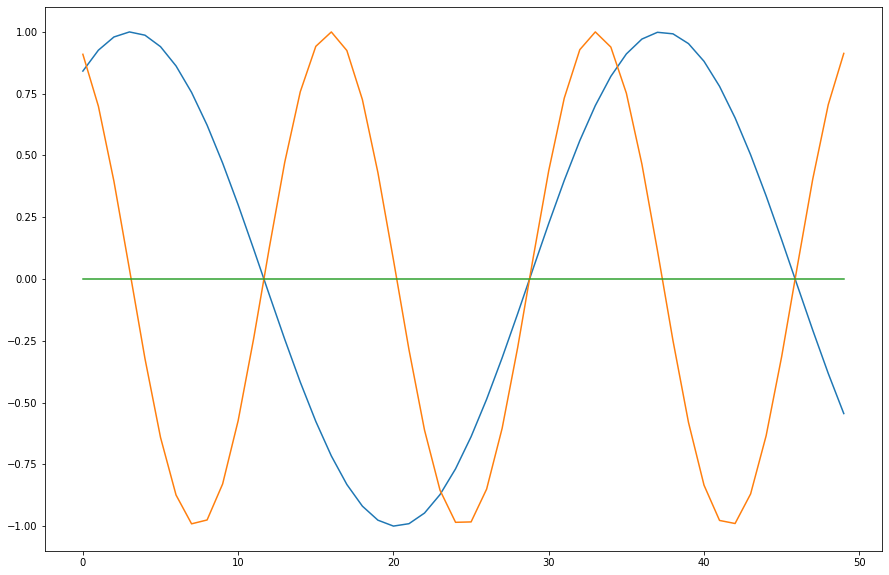

In [26]:
ts1 = np.sin(np.linspace(1, 10))
ts2 = np.sin(2 * np.linspace(1, 10))
ts3 = np.zeros((50,)) 
plt.plot(ts1)
plt.plot(ts2)
plt.plot(ts3)

In [27]:
np.sqrt(np.sum(np.square(ts1 - ts2)))

7.3897194681883756

In [28]:
np.sqrt(np.sum(np.square(ts1 - ts3)))

4.999710697636168

In [29]:
np.sqrt(np.sum(np.square(ts2 - ts3)))

4.935018175874873

In [30]:
np.random.seed(215202)
ts3_noise = np.random.random(ts3.shape)
ts3 = np.zeros((50,)) 
ts3 = ts3 + ts3_noise

In [31]:
np.corrcoef(ts1, ts2)

array([[ 1.        , -0.10087715],
       [-0.10087715,  1.        ]])

In [32]:
np.corrcoef(ts1, ts3)

array([[1.        , 0.19217749],
       [0.19217749, 1.        ]])

In [33]:
np.corrcoef(ts2, ts3 + np.random.random(ts3.shape))

array([[1.        , 0.18666336],
       [0.18666336, 1.        ]])

In [34]:
X = words.iloc[:, 1:271].values

In [35]:
def distDTW(ts1, ts2):
    DTW       = np.full((len(ts1) + 1, len(ts2) + 1), 0, dtype = np.float32)
    DTW[:, 0] = np.inf
    DTW[0, :] = np.inf
    DTW[0, 0] = 0

    for i in range(1, len(ts1) + 1):
        for j in range(1, len(ts2) + 1):
            idx1 = i - 1 
            idx2 = j - 1
            
            dist               = (ts1[idx1] - ts2[idx2])**2
            min_preceding_dist = min(DTW[i-1, j],DTW[i, j-1], DTW[i-1, j-1])

            DTW[i, j] = dist + min_preceding_dist

    return np.sqrt(DTW[len(ts1), len(ts2)])

In [36]:
distDTW(ts1, ts2)

3.7609103

In [37]:
distDTW(ts1, ts3)

3.7185009

In [38]:
distDTW(ts2, ts3)

4.1632533

In [39]:
distDTW(X[0], X[1])

7.77796

In [40]:
dtw.distance(X[0], X[1])

7.777960164340302

In [ ]:
# p = pairwise_distances(X, metric = distDTW)

In [ ]:
# clustering = AgglomerativeClustering(linkage='average', n_clusters=50, affinity = 'precomputed') 
# labels = clustering.fit_predict(p)

In [ ]:
# print(homogeneity_score(words.word, labels))
# print(completeness_score(words.word, labels))

In [ ]:
# res = contingency_matrix(labels, words.word)

In [ ]:
# plt.imshow(res)